In [1]:
import pandas as pd
import numpy as np
import cdt
import networkx as nx
import os
from notears.notears import linear
from notears.notears import utils

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz

import matplotlib.pyplot as plt

import pickle

Detecting 8 CUDA device(s).


In [3]:
def convert_cpdag_format(causal_graph):
    """
    Convert the CPDAG format from CausalGraph (cg.G.graph) to an adjacency matrix format.
    
    Args:
        causal_graph: A CausalGraph object with cg.G.graph as the adjacency matrix.
    
    Returns:
        A NumPy adjacency matrix where:
        - 1 represents an edge (directed or undirected).
        - 0 represents no edge.
    """
    # Extract the graph matrix
    graph_matrix = causal_graph.G.graph
    n = graph_matrix.shape[0]
    
    # Initialize the adjacency matrix
    adjacency_matrix = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            if graph_matrix[j, i] == 1 and graph_matrix[i, j] == -1:
                # Directed edge i -> j
                adjacency_matrix[i, j] = 1
            elif graph_matrix[i, j] == -1 and graph_matrix[j, i] == -1:
                # Undirected edge i -- j
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
            elif graph_matrix[i, j] == 1 and graph_matrix[j, i] == 1:
                # Bidirectional edge i <-> j
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    
    return adjacency_matrix

In [4]:
data_dir = '/cim/ehoney/IFT6168_project/dcdi/data/perfect'

# List of folder names in the data directory
data_folder_names = [
    d
    for d in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, d))
    and d != 'sachs_intervention' and not d.endswith('.zip')
]

data_folder_names.sort()

In [5]:
out_dir = '/cim/ehoney/IFT6168_project/experiments/baseline'

In [6]:
lambda1 = 0.5
loss_type = 'l2'

In [6]:
# metrics = {}

# # Iterate through each data directory
# for data_folder_name in data_folder_names:
#     data_folder_path = os.path.join(data_dir, data_folder_name)
#     print(f"Processing data directory: {data_folder_path}")

#     output_dir = os.path.join(out_dir, data_folder_name)
#     os.makedirs(output_dir, exist_ok=True)

#     metrics[data_folder_name] = {}
    
#     # Iterate through the 10 datasets in the current directory
#     for i in range(1, 11):
#         metrics[data_folder_name][i] = {}

#         # Load the DAG, CPDAG, and observational data
#         dag_path = os.path.join(data_folder_path, f'DAG{i}.npy')
#         cpdag_path = os.path.join(data_folder_path, f'CPDAG{i}.npy')
#         obs_data_path = os.path.join(data_folder_path, f'data{i}.npy')
        
#         dag = np.load(dag_path)
#         cpdag = np.load(cpdag_path)
#         obs_data = np.load(obs_data_path)

#         ## PC algorithm
        
#         # Estimate the CPDAG using the PC algorithm
#         cg = pc(obs_data)
        
#         # Convert the estimated CPDAG to adjacency matrix format
#         estimated_cpdag = convert_cpdag_format(cg)

#         # Save the estimated CPDAG
#         output_path = os.path.join(output_dir, f'PC_alg_CPDAG{i}.npy')
#         np.save(output_path, estimated_cpdag)

#         pc_shd = cdt.metrics.SHD(estimated_cpdag, cpdag, double_for_anticausal=False)
#         metrics[data_folder_name][i]['PC_SHD'] = pc_shd
        

#         ## NOTEARS
#         W_est = linear.notears_linear(obs_data, lambda1=lambda1, loss_type=loss_type)

#         # Save the estimated W matrix
#         output_path = os.path.join(output_dir, f'NOTEARS_W{i}.npy')
#         np.save(output_path, W_est)

#         estimated_dag = (W_est != 0).astype(int)

#         notears_shd = cdt.metrics.SHD(estimated_dag, dag, double_for_anticausal=False)
#         metrics[data_folder_name][i]['NOTEARS_SHD'] = notears_shd

#         # Print SHDs for the current dataset
#         print(f"Dataset {i}: PC SHD = {pc_shd}, NOTEARS SHD = {notears_shd}")

#     # Compute the mean and variance of SHD values for the current directory
#     pc_shd_values = [metrics[data_folder_name][i]['PC_SHD'] for i in range(1, 11)]
#     notears_shd_values = [metrics[data_folder_name][i]['NOTEARS_SHD'] for i in range(1, 11)]
#     mean_pc_shd = np.mean(pc_shd_values)
#     variance_pc_shd = np.var(pc_shd_values)
#     mean_notears_shd = np.mean(notears_shd_values)
#     variance_notears_shd = np.var(notears_shd_values)

#     # Display mean and variance of SHD values
#     print(f"Mean PC SHD for {data_folder_name}: {mean_pc_shd}")
#     print(f"Variance PC SHD for {data_folder_name}: {variance_pc_shd}")
#     print(f"Mean NOTEARS SHD for {data_folder_name}: {mean_notears_shd}")
#     print(f"Variance NOTEARS SHD for {data_folder_name}: {variance_notears_shd}")

# # Save metrics as npy file inside output directory
# metrics_output_path = os.path.join(out_dir, 'metrics.npy')
# np.save(metrics_output_path, metrics)

In [26]:
with open(os.path.join(out_dir, 'metrics_dict.pkl'), 'rb') as f:
    metrics = pickle.load(f)

In [27]:
metrics

{'data_p10_e10_n10000_linear_struct': {1: {'PC_SHD': 0.0, 'NOTEARS_SHD': 5.0},
  2: {'PC_SHD': 6.0, 'NOTEARS_SHD': 9.0},
  3: {'PC_SHD': 0.0, 'NOTEARS_SHD': 6.0},
  4: {'PC_SHD': 0.0, 'NOTEARS_SHD': 9.0},
  5: {'PC_SHD': 0.0, 'NOTEARS_SHD': 11.0},
  6: {'PC_SHD': 0.0, 'NOTEARS_SHD': 10.0},
  7: {'PC_SHD': 0.0, 'NOTEARS_SHD': 8.0},
  8: {'PC_SHD': 0.0, 'NOTEARS_SHD': 5.0},
  9: {'PC_SHD': 0.0, 'NOTEARS_SHD': 6.0},
  10: {'PC_SHD': 0.0, 'NOTEARS_SHD': 5.0}},
 'data_p10_e10_n10000_nn_struct': {1: {'PC_SHD': 2.0, 'NOTEARS_SHD': 11.0},
  2: {'PC_SHD': 8.0, 'NOTEARS_SHD': 13.0},
  3: {'PC_SHD': 5.0, 'NOTEARS_SHD': 8.0},
  4: {'PC_SHD': 9.0, 'NOTEARS_SHD': 10.0},
  5: {'PC_SHD': 1.0, 'NOTEARS_SHD': 8.0},
  6: {'PC_SHD': 3.0, 'NOTEARS_SHD': 9.0},
  7: {'PC_SHD': 12.0, 'NOTEARS_SHD': 12.0},
  8: {'PC_SHD': 5.0, 'NOTEARS_SHD': 8.0},
  9: {'PC_SHD': 1.0, 'NOTEARS_SHD': 6.0},
  10: {'PC_SHD': 10.0, 'NOTEARS_SHD': 6.0}},
 'data_p10_e10_n10000_nnadd_struct': {1: {'PC_SHD': 5.0, 'NOTEARS_SHD': 3.0},


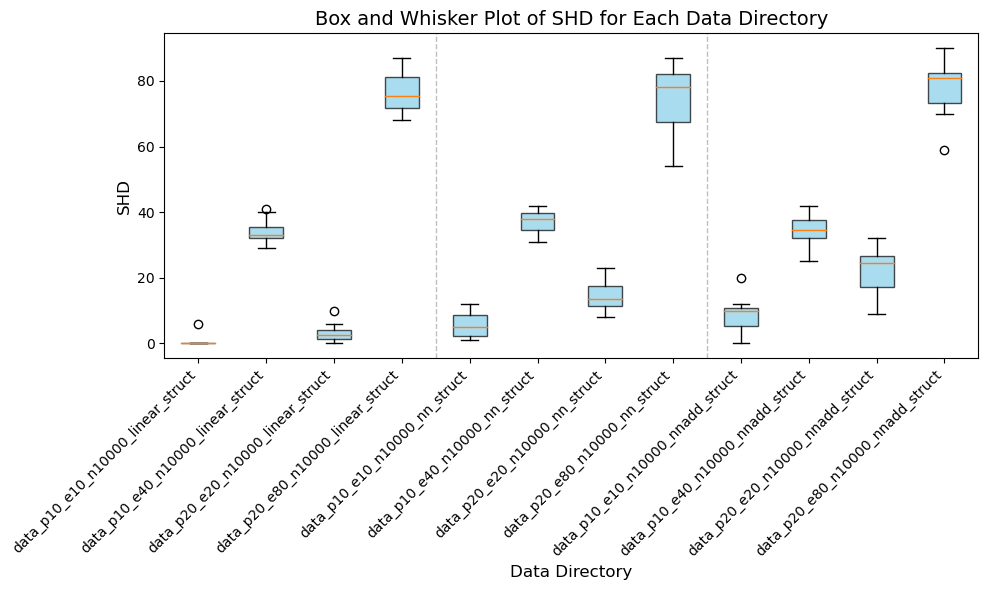

In [16]:
# Prepare data for plotting
data_dirs = []
for struct_type in ['linear_struct', 'nn_struct', 'nnadd_struct']:
    for params in ['p10_e10', 'p10_e40', 'p20_e20', 'p20_e80']:
        dir_name = os.path.join(f'data_{params}_n10000_{struct_type}')
        data_dirs.append(dir_name)
short_data_dirs = [os.path.basename(dir) for dir in data_dirs]  # Extract key info from paths
# shd_values_per_dir = [metrics[dir]['PC_SHD'] for dir in data_dirs]  # Use SHD values for boxplot
pc_shd_values = [[metrics[dir][i]['PC_SHD'] for i in range(1, 11)] for dir in data_dirs]

# Calculate group boundaries
group_boundaries = [i * 4 for i in range(1, len(['linear_struct', 'nn_struct', 'nnadd_struct']))]

# Create the plot
plt.figure(figsize=(10, 6))
plt.boxplot(pc_shd_values, labels=short_data_dirs, patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7))

# Add vertical lines between groups
for boundary in group_boundaries:
    plt.axvline(x=boundary + 0.5, color='grey', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Data Directory', fontsize=12)
plt.ylabel('SHD', fontsize=12)
plt.title('Box and Whisker Plot of SHD for Each Data Directory', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()



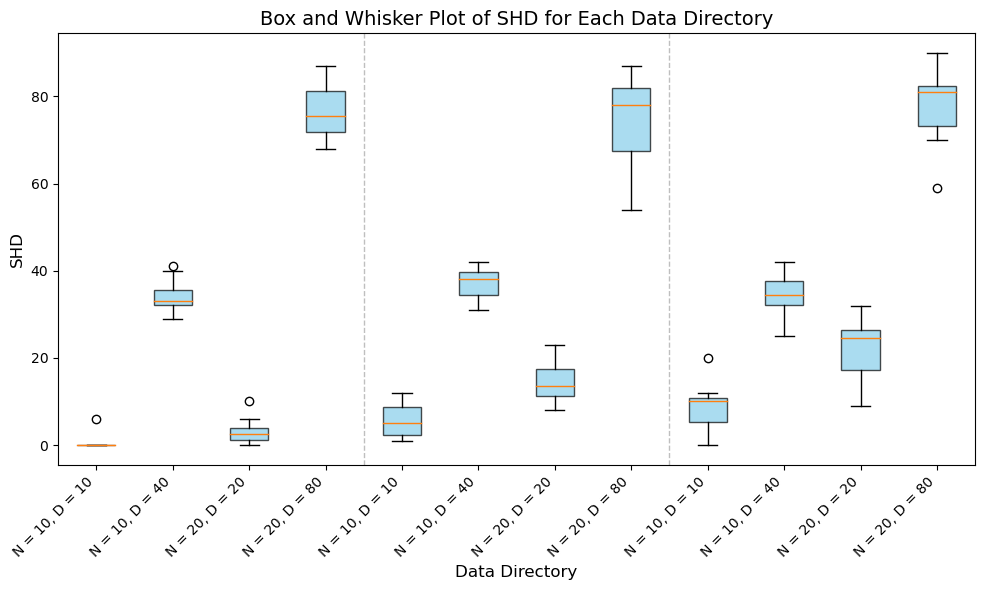

In [21]:
# Prepare custom x-axis labels
custom_labels = [
    f"N = {dir.split('_')[1][1:]}, D = {dir.split('_')[2][1:]}" 
    for dir in short_data_dirs
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.boxplot(pc_shd_values, labels=custom_labels, patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7))

# Add vertical lines between groups
for boundary in group_boundaries:
    plt.axvline(x=boundary + 0.5, color='grey', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Data Directory', fontsize=12)
plt.ylabel('SHD', fontsize=12)
plt.title('Box and Whisker Plot of SHD for Each Data Directory', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


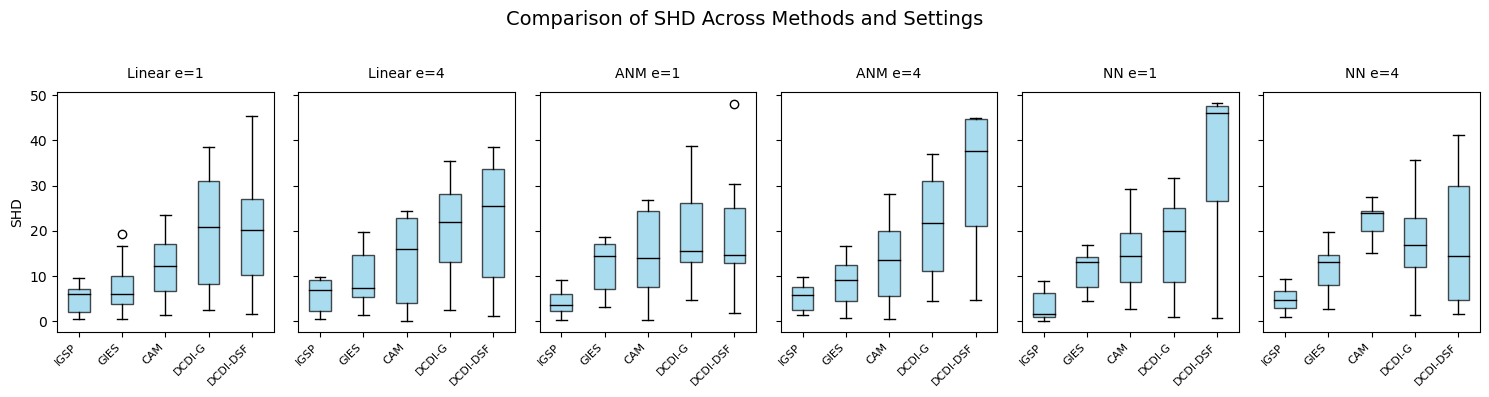

In [29]:
# Plot configuration
fig, axes = plt.subplots(1, len(settings), figsize=(15, 4), sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Iterate over settings to create subplots for SHD
metric = 'SHD'
for setting_idx, setting in enumerate(settings):
    ax = axes[setting_idx] if len(settings) > 1 else axes
    
    # Boxplot for the current setting
    ax.boxplot(
        data[metric][setting],
        patch_artist=True,
        boxprops=dict(facecolor='skyblue', alpha=0.7),
        medianprops=dict(color='black'),
        showfliers=True
    )
    
    # Set x-axis labels (methods)
    ax.set_xticks(range(1, len(methods) + 1))
    ax.set_xticklabels(methods, rotation=45, ha='right', fontsize=8)
    
    # Set title for each subplot
    ax.set_title(setting, fontsize=10, pad=10)
    
    # Set y-axis label for the leftmost subplot
    if setting_idx == 0:
        ax.set_ylabel(metric, fontsize=10)

# Add a global title
fig.suptitle('Comparison of SHD Across Methods and Settings', fontsize=14)

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


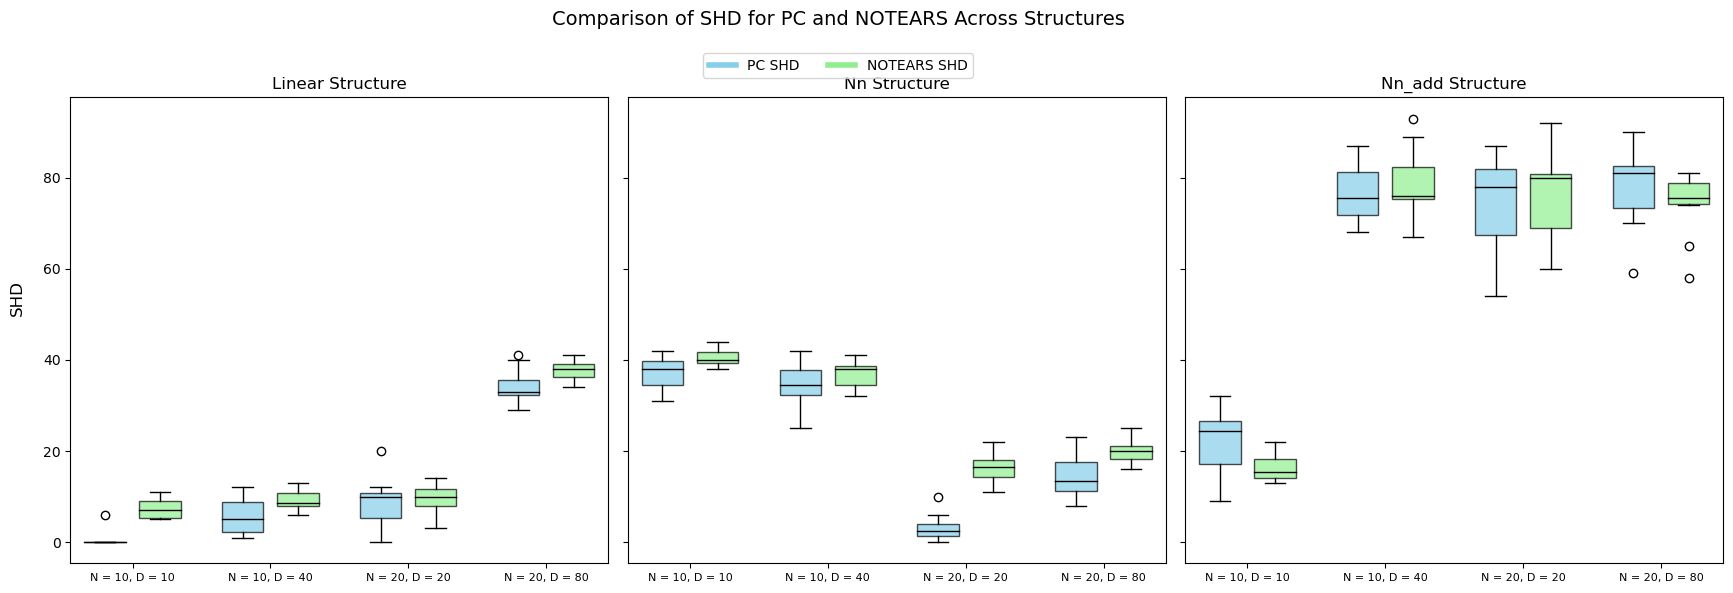

In [41]:
# Prepare data for plotting
struct_types = ['linear', 'nn', 'nn_add']
struct_indices = [[i for i, label in enumerate(struct_type_labels) if label == struct] for struct in struct_types]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, struct, indices in zip(axes, struct_types, struct_indices):
    # Extract data for the current structure
    pc_shd_values_struct = [pc_shd_values[i] for i in indices]
    notears_shd_values_struct = [notears_shd_values[i] for i in indices]
    
    # Extract N and D values for labels
    short_data_dirs_struct = [
        f"N = {data_dirs[i].split('_')[1][1:]}, D = {data_dirs[i].split('_')[2][1:]}" 
        for i in indices
    ]

    # Plot PC SHD
    pc_plot = ax.boxplot(pc_shd_values_struct, positions=np.arange(len(indices)) * 2.0 - 0.4, widths=0.6,
                         patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7), medianprops=dict(color='black'),
                         labels=short_data_dirs_struct if len(indices) <= 10 else None)

    # Plot NOTEARS SHD
    notears_plot = ax.boxplot(notears_shd_values_struct, positions=np.arange(len(indices)) * 2.0 + 0.4, widths=0.6,
                              patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7), medianprops=dict(color='black'))

    # Customize the subplot
    ax.set_title(f'{struct.capitalize()} Structure', fontsize=12)
    ax.set_xticks(np.arange(len(indices)) * 2.0)
    ax.set_xticklabels(short_data_dirs_struct, rotation=0, ha='center', fontsize=8)

# Add shared y-axis label
fig.text(0.04, 0.5, 'SHD', va='center', rotation='vertical', fontsize=12)

# Add a global title
fig.suptitle('Comparison of SHD for PC and NOTEARS Across Structures', fontsize=14)

# Add a legend outside of the subplots
handles = [
    plt.Line2D([0], [0], color='skyblue', lw=4, label='PC SHD'),
    plt.Line2D([0], [0], color='lightgreen', lw=4, label='NOTEARS SHD')
]
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=2, fontsize=10)

# Adjust layout and show the plot
plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.show()


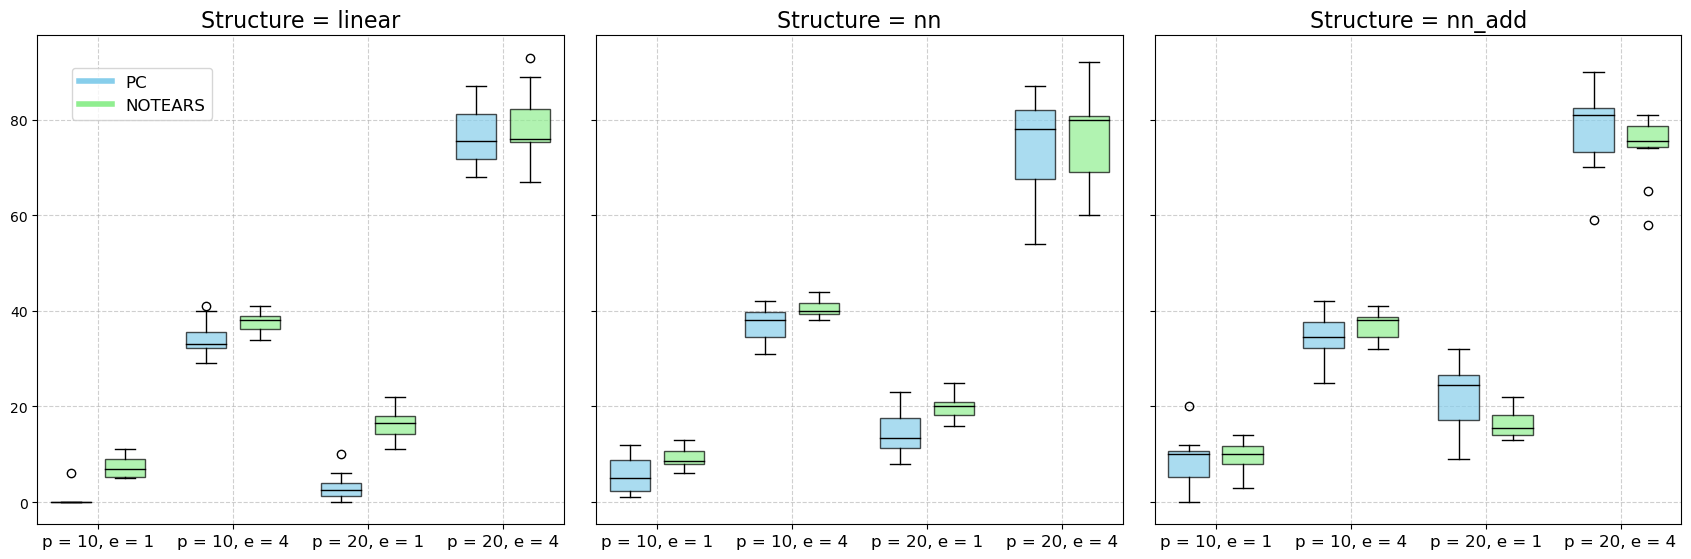

In [ ]:
# Define pc_shd_values and notears_shd_values
pc_shd_values = [[metrics[dir][i]['PC_SHD'] for i in range(1, 11)] for dir in data_dirs]
notears_shd_values = [[metrics[dir][i]['NOTEARS_SHD'] for i in range(1, 11)] for dir in data_dirs]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterate over struct_types and their corresponding indices
for ax, struct, indices in zip(axes, struct_types, struct_indices):
    # Extract data for the current structure
    pc_shd_values_struct = [pc_shd_values[i] for i in indices]
    notears_shd_values_struct = [notears_shd_values[i] for i in indices]
    # Extract N and D values for labels
    short_data_dirs_struct = [
        f"p = {data_dirs[i].split('_')[1][1:]}, e = {int(data_dirs[i].split('_')[2][1:]) / int(data_dirs[i].split('_')[1][1:]):.0f}" 
        for i in indices
    ]

    # Plot PC SHD
    ax.boxplot(pc_shd_values_struct, positions=np.arange(len(indices)) * 2.0 - 0.4, widths=0.6,
               patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7), medianprops=dict(color='black'))

    # Plot NOTEARS SHD
    ax.boxplot(notears_shd_values_struct, positions=np.arange(len(indices)) * 2.0 + 0.4, widths=0.6,
               patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7), medianprops=dict(color='black'))

    # Customize the subplot
    ax.set_title(f'Structure = {struct}', fontsize=16)  # Increased font size for title
    ax.set_xticks(np.arange(len(indices)) * 2.0)
    ax.set_xticklabels(short_data_dirs_struct, rotation=0, ha='center', fontsize=12)  # Increased font size for x-ticks
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines

# Add shared y-axis label
fig.text(0.04, 0.5, 'SHD', va='center', rotation='vertical', fontsize=16)  # Increased font size for y-axis label

# Add a legend outside of the subplots
handles = [
    plt.Line2D([0], [0], color='skyblue', lw=4, label='PC'),
    plt.Line2D([0], [0], color='lightgreen', lw=4, label='NOTEARS')
]
axes[0].legend(handles=handles, loc='upper left', bbox_to_anchor=(0.05, 0.95), ncol=1, fontsize=12)  # Increased font size for legend

# Adjust layout and show the plot
plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.show()
